# Deep Learning
## Assignment 3
The goal of this assignment is to explore regularization technique.

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pickle_file = './data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

## Problem 1
Introduce and tune L2 regularization for both logistic and neural network models.

In [10]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
        beta_regul * tf.nn.l2_loss(weights)
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [11]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dict telling the session where to feed the batch.
        # The key is the placeholder node to be fed and value is the ndarray
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 20.668545
Minibatch accuracy: 12.5%
Validation accuracy: 13.0%
Minibatch loss at step 500: 2.467217
Minibatch accuracy: 76.6%
Validation accuracy: 75.8%
Minibatch loss at step 1000: 1.762559
Minibatch accuracy: 78.1%
Validation accuracy: 79.0%
Minibatch loss at step 1500: 0.871309
Minibatch accuracy: 85.9%
Validation accuracy: 80.3%
Minibatch loss at step 2000: 0.828484
Minibatch accuracy: 87.5%
Validation accuracy: 80.9%
Minibatch loss at step 2500: 0.844550
Minibatch accuracy: 80.5%
Validation accuracy: 81.5%
Minibatch loss at step 3000: 0.774282
Minibatch accuracy: 82.0%
Validation accuracy: 81.9%
Test accuracy: 89.0%


In [12]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -1, 0.1)]
accuracy_val = []

for beta in regul_val:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dict telling the session where to feed the batch.
            # The key is the placeholder node to be fed and value is the ndarray
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

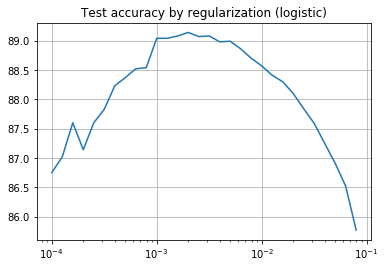

In [16]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

On neural network

In [19]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
        beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [20]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dict telling the session where to feed the batch.
        # The key is the placeholder node to be fed and value is the ndarray
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 645.036133
Minibatch accuracy: 5.5%
Validation accuracy: 30.5%
Minibatch loss at step 500: 196.086380
Minibatch accuracy: 80.5%
Validation accuracy: 78.3%
Minibatch loss at step 1000: 115.433235
Minibatch accuracy: 78.9%
Validation accuracy: 81.2%
Minibatch loss at step 1500: 68.792587
Minibatch accuracy: 85.9%
Validation accuracy: 83.4%
Minibatch loss at step 2000: 41.404346
Minibatch accuracy: 89.1%
Validation accuracy: 84.6%
Minibatch loss at step 2500: 25.123196
Minibatch accuracy: 89.8%
Validation accuracy: 85.6%
Minibatch loss at step 3000: 15.464598
Minibatch accuracy: 87.5%
Validation accuracy: 86.5%
Test accuracy: 93.3%


## Problem 2
Demonstrate an extreme case of overfitting.

In [22]:
batch_size = 124
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
        beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [24]:
num_steps = 101
num_batches = 4

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = step % num_batches
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dict telling the session where to feed the batch.
        # The key is the placeholder node to be fed and value is the ndarray
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 10 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 497.716217
Minibatch accuracy: 25.0%
Validation accuracy: 14.8%
Minibatch loss at step 10: 353.135498
Minibatch accuracy: 100.0%
Validation accuracy: 19.5%
Minibatch loss at step 20: 349.621216
Minibatch accuracy: 100.0%
Validation accuracy: 19.5%
Minibatch loss at step 30: 346.141449
Minibatch accuracy: 100.0%
Validation accuracy: 19.5%
Minibatch loss at step 40: 342.696014
Minibatch accuracy: 100.0%
Validation accuracy: 19.5%
Minibatch loss at step 50: 339.285004
Minibatch accuracy: 100.0%
Validation accuracy: 19.5%
Minibatch loss at step 60: 335.908691
Minibatch accuracy: 100.0%
Validation accuracy: 19.5%
Minibatch loss at step 70: 332.565399
Minibatch accuracy: 100.0%
Validation accuracy: 19.5%
Minibatch loss at step 80: 329.255951
Minibatch accuracy: 100.0%
Validation accuracy: 19.5%
Minibatch loss at step 90: 325.978790
Minibatch accuracy: 100.0%
Validation accuracy: 19.5%
Minibatch loss at step 100: 322.734436
Minibatch accuracy: 100.0%
Vali

## Problem 3
Introduce Dropout on the hidden layer of the neural network. Dropout should only be used during the training, not the evaluation.

In [26]:
batch_size = 124
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    logits = tf.matmul(drop1, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
        beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [27]:
num_steps = 101
num_batches = 4

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = step % num_batches
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dict telling the session where to feed the batch.
        # The key is the placeholder node to be fed and value is the ndarray
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 10 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 785.952271
Minibatch accuracy: 11.3%
Validation accuracy: 18.7%
Minibatch loss at step 10: 323.374817
Minibatch accuracy: 93.5%
Validation accuracy: 65.0%
Minibatch loss at step 20: 316.026917
Minibatch accuracy: 96.0%
Validation accuracy: 65.2%
Minibatch loss at step 30: 306.416382
Minibatch accuracy: 99.2%
Validation accuracy: 65.3%
Minibatch loss at step 40: 303.824890
Minibatch accuracy: 99.2%
Validation accuracy: 64.8%
Minibatch loss at step 50: 300.778748
Minibatch accuracy: 99.2%
Validation accuracy: 65.8%
Minibatch loss at step 60: 297.942322
Minibatch accuracy: 99.2%
Validation accuracy: 65.0%
Minibatch loss at step 70: 294.231812
Minibatch accuracy: 100.0%
Validation accuracy: 65.6%
Minibatch loss at step 80: 291.557953
Minibatch accuracy: 99.2%
Validation accuracy: 67.3%
Minibatch loss at step 90: 288.432465
Minibatch accuracy: 100.0%
Validation accuracy: 67.3%
Minibatch loss at step 100: 285.562531
Minibatch accuracy: 100.0%
Validation 